In [ ]:
# train 
!python scripts/train_diffusion.py /home/chen/project/ai/MiDiffusion/config/bedrooms_mixed.yaml --experiment_tag bedroom
!python scripts/train_diffusion.py --gpu 1 /home/chen/project/ai/MiDiffusion/config/bedrooms_mixed.yaml --experiment_tag livingroom

In [ ]:
#inference
!python scripts/generate_results.py   /home/chen/project/ai/MiDiffusion/output/log/bedroom/model_38000 --result_tag bedroom

In [ ]:
#render
!python ../ThreedFront/scripts/render_results.py output/predicted_results/bedroom/results.pkl

In [ ]:
#render scene
!python ../ThreedFront/scripts/render_threedfront_scene_results.py   output/predicted_results/bedroom/results.pkl   --without_screen --path_to_pickled_3d_future_model /home/chen/project/ai/ThreedFront/output/threed_future_model_bedroom.pkl --index 4


evaluate_kl_divergence_object_category.py: Compute KL-divergence between ground-truth and synthesized object category distributions.
compute_fid_scores.py: Compute average FID or KID (if run with "--compute_kid" flag) between ground-truth and synthesized layout images.
synthetic_vs_real_classifier.py: Train image classifier to distinguish real and synthetic projection images, and compute average classification accuracy.
bbox_analysis.py: Count the number of out-of-boundary object bounding boxes and compute pairwise bounding boxes IoU (this requires sampled floor plan boundary and normal points).

In [20]:
#kl_divergence 
!python ../ThreedFront/scripts/evaluate_kl_divergence_object_category.py output/predicted_results/bedroom/results.pkl 

No GUI library found. Simple-3dviz will be running headless only.
Received 1000 synthesized scenes
[          armchair]: target: 0.0072 / synth: 0.0035
[         bookshelf]: target: 0.0084 / synth: 0.0062
[           cabinet]: target: 0.0228 / synth: 0.0269
[      ceiling_lamp]: target: 0.0623 / synth: 0.0567
[             chair]: target: 0.0240 / synth: 0.0255
[  children_cabinet]: target: 0.0060 / synth: 0.0058
[      coffee_table]: target: 0.0024 / synth: 0.0008
[              desk]: target: 0.0204 / synth: 0.0141
[        double_bed]: target: 0.1641 / synth: 0.1686
[    dressing_chair]: target: 0.0048 / synth: 0.0066
[    dressing_table]: target: 0.0228 / synth: 0.0226
[          kids_bed]: target: 0.0048 / synth: 0.0056
[        nightstand]: target: 0.2527 / synth: 0.2705
[      pendant_lamp]: target: 0.1341 / synth: 0.1298
[             shelf]: target: 0.0048 / synth: 0.0068
[        single_bed]: target: 0.0251 / synth: 0.0201
[              sofa]: target: 0.0012 / synth: 0.0027


In [1]:
!pip install https://extras.wxpython.org/wxPython4/extras/linux/gtk3/ubuntu-22.04/wxPython-4.2.0-cp310-cp310-linux_x86_64.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 MB 1.0 MB/s eta 0:00:0000:0100:06


In [ ]:
#KID evaluation
!python ../ThreedFront/scripts/compute_fid_scores.py output/predicted_results/bedroom/results.pkl --compute_kid --synthesized_directory /home/chen/project/ai/MiDiffusion/output/predicted_results/bedroom/ --output_directory /home/chen/project/ai/MiDiffusion/output/bedroom_eva

 #FID evaluation
!python ../ThreedFront/scripts/compute_fid_scores.py output/predicted_results/bedroom/results.pkl --synthesized_directory /home/chen/project/ai/MiDiffusion/output/predicted_results/bedroom/ --output_directory /home/chen/project/ai/MiDiffusion/output/bedroom_eva      

# Visualization trainning loss

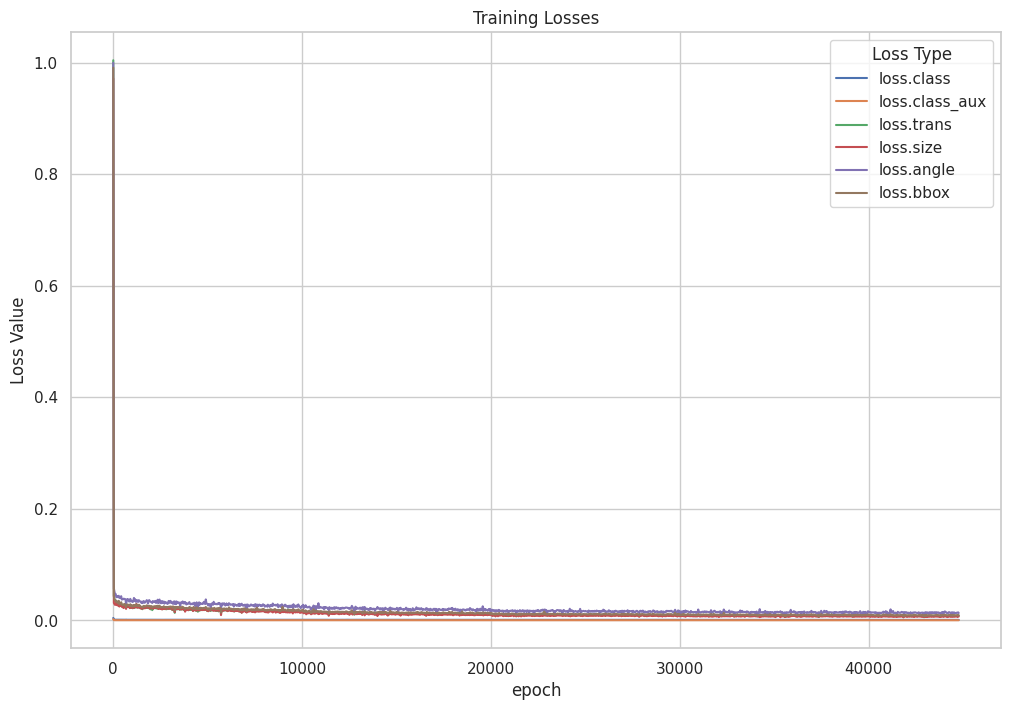

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

# 定义正则表达式解析日志行
log_pattern = re.compile(r'epoch: (\d+) - batch: (\d+) - loss: ([\d.]+) - loss.class: ([\d.]+) - loss.class_aux: ([\d.]+) - loss.trans: ([\d.]+) - loss.size: ([\d.]+) - loss.angle: ([\d.]+) - loss.bbox: ([\d.]+) - gradnorm: ([\d.]+) - lr: ([\d.]+)')

# 创建一个空的DataFrame
log_data = {
    "epoch": [],
    "batch": [],
    "loss": [],
    "loss.class": [],
    "loss.class_aux": [],
    "loss.trans": [],
    "loss.size": [],
    "loss.angle": [],
    "loss.bbox": [],
    "gradnorm": [],
    "lr": []
}

# 读取日志文件并解析每一行
with open('/home/chen/project/ai/MiDiffusion/output/train_log/log.txt', 'r') as file:
    sample_r = 1000
    i = 0
    for line in file:
        i =i+1
        if i%sample_r != 1 : continue
        match = log_pattern.match(line)
        if match:
            log_data["epoch"].append(int(match.group(1)))
            log_data["batch"].append(int(match.group(2)))
            log_data["loss"].append(float(match.group(3)))
            log_data["loss.class"].append(float(match.group(4)))
            log_data["loss.class_aux"].append(float(match.group(5)))
            log_data["loss.trans"].append(float(match.group(6)))
            log_data["loss.size"].append(float(match.group(7)))
            log_data["loss.angle"].append(float(match.group(8)))
            log_data["loss.bbox"].append(float(match.group(9)))
            log_data["gradnorm"].append(float(match.group(10)))
            log_data["lr"].append(float(match.group(11)))

# 将解析的数据转换为DataFrame
df = pd.DataFrame(log_data)

# 将数据转换为长格式以便于绘图
df_long = df.melt(id_vars=['epoch', 'batch'], 
                  value_vars=['loss.class', 'loss.class_aux', 'loss.trans', 
                              'loss.size', 'loss.angle', 'loss.bbox'],
                  var_name='loss_type', value_name='loss_value')

# 使用seaborn绘制不同损失类型的训练曲线
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_long, x='epoch', y='loss_value', hue='loss_type')
plt.title('Training Losses')
plt.xlabel('epoch')
plt.ylabel('Loss Value')
plt.legend(title='Loss Type')
plt.show()